In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams['figure.figsize'] = (12,5)
pd.set_option('display.max_columns', 50)


TASK 1A Load & Prepare Data

In [4]:
DATA_PATH = Path('household_power_consumption.txt')
df = pd.read_csv(DATA_PATH, sep=';', low_memory=False, na_values='?', parse_dates={'datetime':['Date','Time']}, infer_datetime_format=True)
df = df.set_index('datetime').sort_index()
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.shape


(2075259, 7)

TASK 1B Time-series trend, missingness, abnormal daily outliers

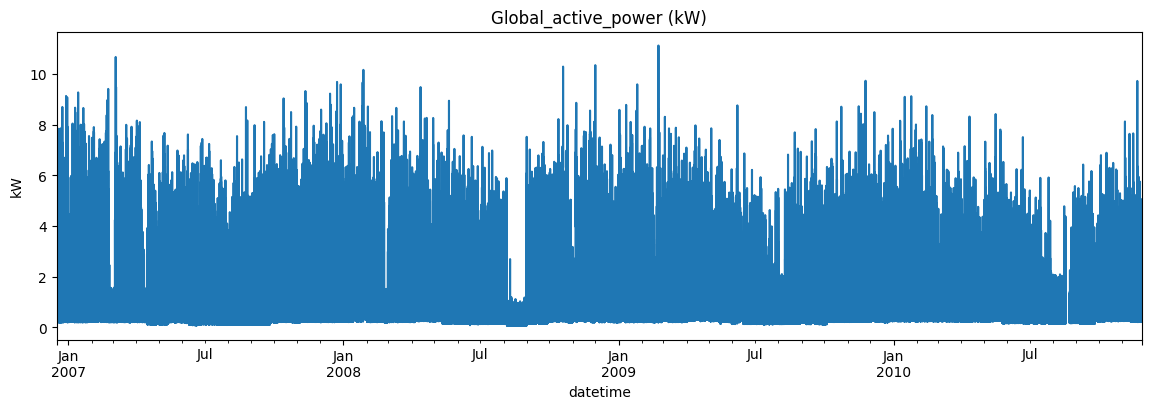

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Global_active_power      1.252
Global_reactive_power    1.252
Voltage                  1.252
Global_intensity         1.252
Sub_metering_1           1.252
Sub_metering_2           1.252
Sub_metering_3           1.252
dtype: float64


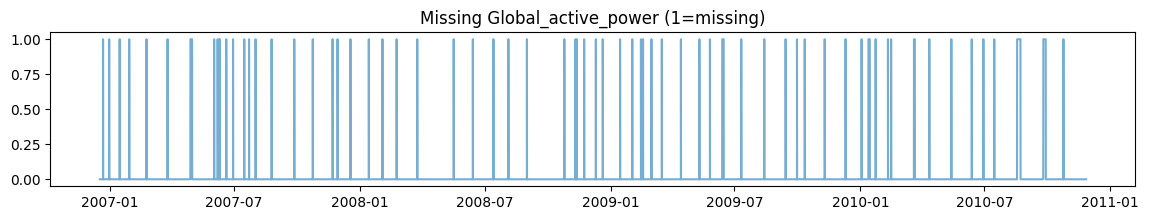

,Global_active_power
datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-23,3.314851
2006-12-26,2.732021
2006-12-31,2.426525


In [5]:
fig, ax = plt.subplots(figsize=(14,4))
df['Global_active_power'].plot(ax=ax)
ax.set_title('Global_active_power (kW)')
ax.set_ylabel('kW')
plt.show()
missing_per_col = df.isna().sum()
pct_missing = (missing_per_col / len(df)) * 100
print(missing_per_col)
print(pct_missing.round(3))
fig, ax = plt.subplots(figsize=(14,2))
ax.plot(df.index, df['Global_active_power'].isna().astype(int), alpha=0.6)
ax.set_ylim(-0.05,1.05)
ax.set_title('Missing Global_active_power (1=missing)')
plt.show()
daily_mean = df['Global_active_power'].resample('D').mean()
z = (daily_mean - daily_mean.mean()) / daily_mean.std()
outliers = daily_mean[abs(z) > 3]
display(outliers.head())


TASK 1C Hourly & daily patterns

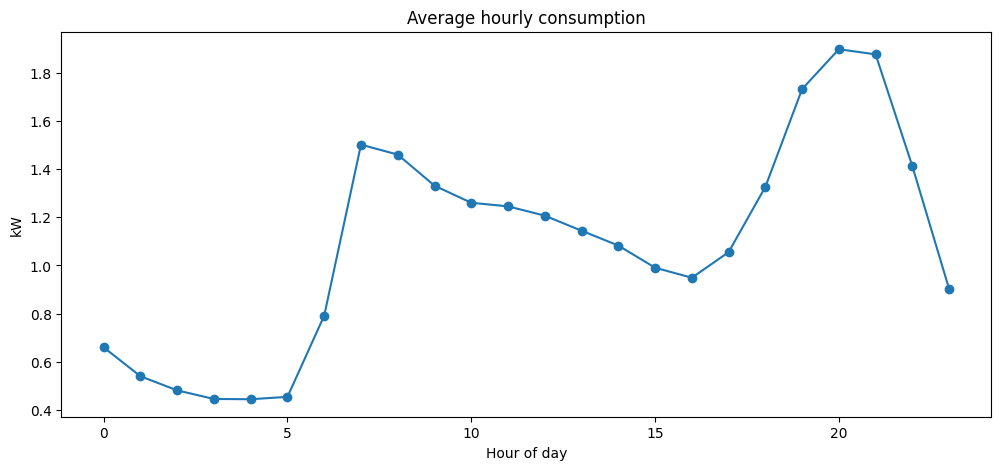

High usage hours (top 3): [20, 21, 19]
Low usage hours (bottom 3): [4, 3, 5]


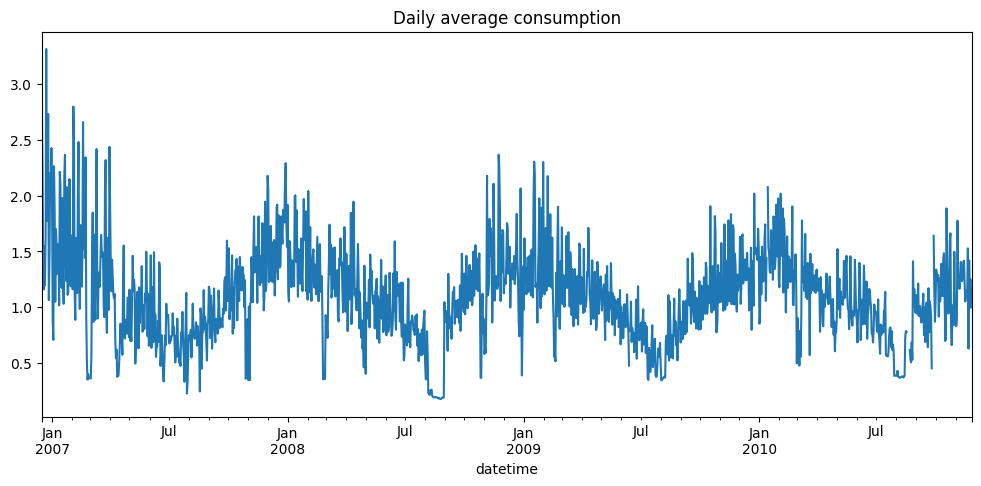

In [6]:
hourly_avg = df['Global_active_power'].groupby(df.index.hour).mean()
fig, ax = plt.subplots()
hourly_avg.plot(ax=ax, marker='o', title='Average hourly consumption')
ax.set_xlabel('Hour of day')
ax.set_ylabel('kW')
plt.show()
high_usage = list(hourly_avg.sort_values(ascending=False).head(3).index)
low_usage = list(hourly_avg.sort_values().head(3).index)
print('High usage hours (top 3):', high_usage)
print('Low usage hours (bottom 3):', low_usage)
daily_avg = df['Global_active_power'].resample('D').mean()
fig, ax = plt.subplots()
daily_avg.plot(ax=ax, title='Daily average consumption')
plt.show()


TASK 2A Prepare windowed dataset for forecasting

In [7]:
def create_supervised(series, window=24, horizon=1):
    arr = series.values
    idx = series.index
    X, y, y_index = [], [], []
    L = len(arr)
    for i in range(window, L - horizon + 1):
        X.append(arr[i-window:i])
        y.append(arr[i + horizon - 1])
        y_index.append(idx[i + horizon - 1])
    return np.array(X), np.array(y), pd.to_datetime(y_index)
ts = df['Global_active_power'].asfreq('H')
ts_interp = ts.interpolate(limit_direction='both')
window = 24
horizon = 1
X, y, y_idx = create_supervised(ts_interp, window=window, horizon=horizon)
X.shape, y.shape


((34564, 24), (34564,))

TASK 2B Train forecasting model and predict (RandomForest example)

In [9]:
n = len(X)
split = int(n * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
idx_train, idx_test = y_idx[:split], y_idx[split:]
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_test = rf.predict(X_test)
mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
print('MAE', round(mae,4), 'RMSE', round(rmse,4))

MAE 0.5018 RMSE 0.7361


TASK 2C Plot predicted vs actual

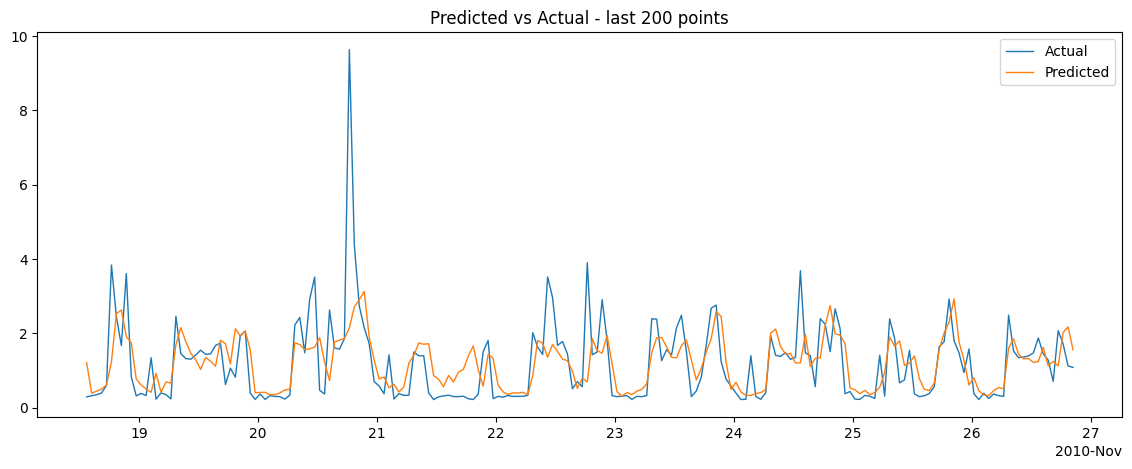

In [10]:
N = 200
sel = slice(max(0, len(y_test)-N), len(y_test))
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(idx_test[sel], y_test[sel], label='Actual', linewidth=1)
ax.plot(idx_test[sel], pred_test[sel], label='Predicted', linewidth=1)
ax.set_title('Predicted vs Actual - last {} points'.format(N))
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.show()


TASK 3A Anomaly detection (daily) and visualization

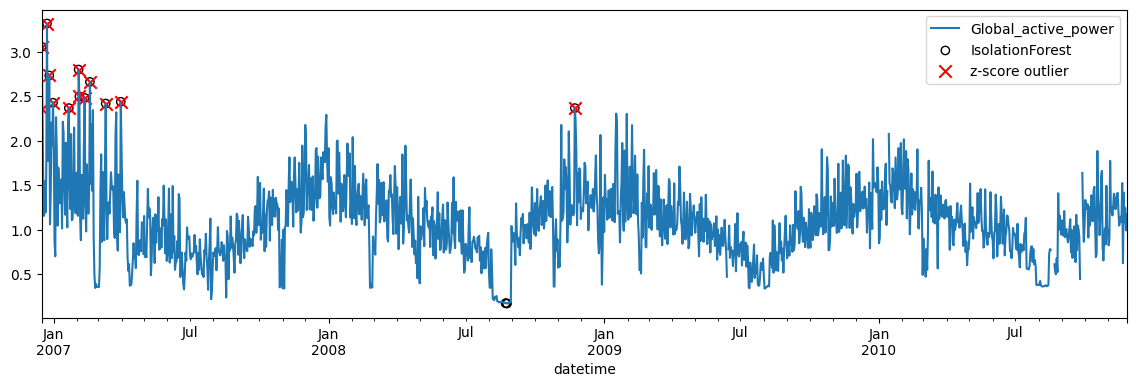

In [11]:
sdf = df[['Global_active_power']].dropna().resample('D').mean()
clf = IsolationForest(contamination=0.01, random_state=42)
vals = sdf.values
clf.fit(vals)
sdf['anomaly'] = clf.predict(vals)
anom_dates = sdf[sdf['anomaly']==-1].index
fig, ax = plt.subplots(figsize=(14,4))
daily_mean.plot(ax=ax)
ax.scatter(anom_dates, daily_mean.reindex(anom_dates), marker='o', facecolors='none', edgecolors='k', label='IsolationForest')
ax.scatter(outliers.index, outliers.values, marker='x', color='red', s=80, label='z-score outlier')
ax.legend()
plt.show()


TASK 3B Clustering daily consumption profiles and visualize clusters

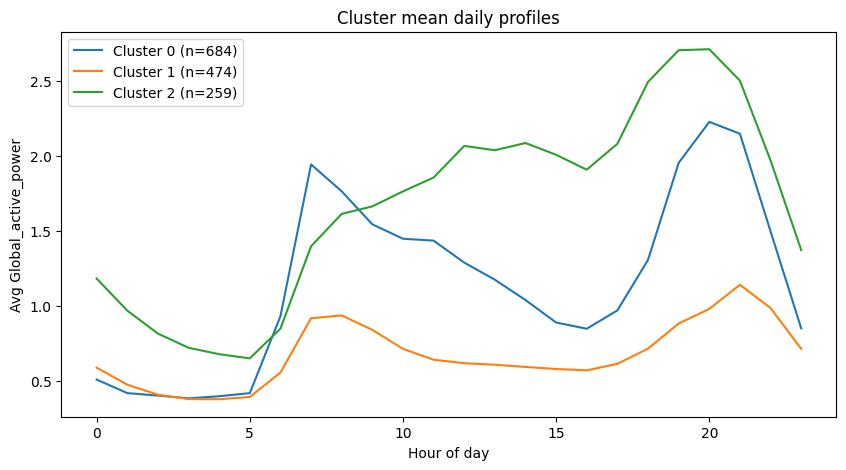

{0: {'size': 684, 'mean_consumption': 1.1590020748567176, 'peak_hour': 20}, 1: {'size': 474, 'mean_consumption': 0.677489971748003, 'peak_hour': 21}, 2: {'size': 259, 'mean_consumption': 1.671724940372235, 'peak_hour': 20}}


In [12]:
hourly_pivot = df['Global_active_power'].groupby([df.index.date, df.index.hour]).mean().unstack()
hourly_pivot.index = pd.to_datetime(hourly_pivot.index)
hourly_pivot = hourly_pivot.dropna()
scaler = StandardScaler()
X_clust = scaler.fit_transform(hourly_pivot.values)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_clust)
labels = kmeans.labels_
hourly_pivot['cluster'] = labels
cluster_means = hourly_pivot.groupby('cluster').mean()
fig, ax = plt.subplots(figsize=(10,5))
for cid in cluster_means.index:
    ax.plot(cluster_means.columns.astype(int), cluster_means.loc[cid].values, label=f'Cluster {cid} (n={(hourly_pivot.cluster==cid).sum()})')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Avg Global_active_power')
ax.set_title('Cluster mean daily profiles')
ax.legend()
plt.show()
chars = {}
for cid in range(n_clusters):
    rows = hourly_pivot[hourly_pivot['cluster']==cid].drop(columns='cluster').values
    size = rows.shape[0]
    mean_consumption = rows.mean()
    peak_hour = int(np.nanargmax(rows.mean(axis=0)))
    chars[cid] = {'size': int(size), 'mean_consumption': float(mean_consumption), 'peak_hour': peak_hour}
print(chars)


TASK 4 Rule-based consumption category and example output

In [13]:
last_pred = float(pred_test[-1]) if 'pred_test' in globals() else float(ts_interp.dropna().iloc[-1])
if last_pred < 1.0:
    cat = 'Low Usage'
    sug = 'Good — maintain efficiency.'
elif last_pred < 3.0:
    cat = 'Medium Usage'
    sug = 'Shift heavy appliances to off-peak hours.'
else:
    cat = 'High Usage'
    sug = 'Investigate heavy-load appliances and optimize usage.'
print('Predicted Global_active_power:', round(last_pred,3))
print('Assigned Category:', cat)
print('Suggestion:', sug)


Predicted Global_active_power: 1.556
Assigned Category: Medium Usage
Suggestion: Shift heavy appliances to off-peak hours.
